<a href="https://colab.research.google.com/github/envirodatascience/final-project-urban-treeam/blob/main/Les_UtilityLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from plotnine import *

In [2]:
%%capture
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/all_trees_58_1712257580.csv"
df=pd.read_csv("/content/all_trees_58_1712257580.csv")
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/Neighborhoods.zip"
! unzip /content/Neighborhoods.zip
nbhds= "/content/New_Haven_CT_Neighborhoods.shp"
nbhds=gpd.read_file(nbhds)

In [112]:
df.head()

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Organization,Neighborhood,Planted_Date,Department,Latin_Genus,Common_Genus,Last_Editor,Sites
0,4,41.328957,-72.975426,Vacant Site,Vacant Site,Stump,27.0,Yes,Sidewalk Planting Strip,NaN,Amity,NaN,Street Tree,Vacant Site,Vacant Site,Les Welker,4
1,5,41.265270,-72.892364,Gleditsia triacanthos,Honeylocust,NaN,23.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Gleditsia,Honeylocust,Mitch Baron,5
2,6,41.323589,-72.908722,Cornus florida,"Dogwood, Flowering",NaN,18.0,No,Sidewalk Tree Pit,NaN,East Rock,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,6
3,7,41.263393,-72.890724,Cornus kousa,"Dogwood, Kousa",NaN,3.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,7
4,8,41.326874,-72.916588,Cornus kousa,"Dogwood, Kousa",NaN,4.0,No,Sidewalk Tree Pit,NaN,Prospect Hill,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,8


Based on prior knowlege of the dataset, I know there are some specific things I want to filter out.

1. There are some vacant sites, which are labeled as such in their latin and common names. These don't represent trees anymore, so I don't want to include them.

2. There are park and greenspace trees included in this dataset. I only want to assess street trees.

3. There is a "last editor" whose name is associated with all the trees that have not been edited since the city and URI started using the Treekeeper software and formally registering the presence of powerlines. I am removing all these records because there is no way to assign them to utility wire presence with any amount of certainty (with my resources and skill set).

4. I want to remove small (recently planted) trees because they have not yet had the chance to decline. I did not use the "planted date" to filter because I believe this field is not always properly populated. Instead, I used 2.1 as the cut off, because all trees are input as 2 when they are planted

5. I am removing trees without a recorded condition. This is not common for trees that have been inventoried or maintained, but there are still a few.

In [3]:
df = df[~df['Common_Name'].str.contains('Vacant Site', case=False)]
df = df[df['Department'].str.contains('Street Tree', case=False)]
df = df[~df['Last_Editor'].str.contains('Alex Foreman', case=False)]
df = df[df['Longitude'] >= -73]
df = df[df['DBH'] >= 2.1]
df.dropna(subset=['Condition'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12295 entries, 6 to 30487
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Site_ID       12295 non-null  int64  
 1   Latitude      12295 non-null  float64
 2   Longitude     12295 non-null  float64
 3   Latin_Name    12295 non-null  object 
 4   Common_Name   12295 non-null  object 
 5   Condition     12295 non-null  object 
 6   DBH           12295 non-null  float64
 7   Wire          12295 non-null  object 
 8   Grow_Space    12295 non-null  object 
 9   Organization  1672 non-null   object 
 10  Neighborhood  12295 non-null  object 
 11  Planted_Date  1887 non-null   object 
 12  Department    12295 non-null  object 
 13  Latin_Genus   12295 non-null  object 
 14  Common_Genus  12295 non-null  object 
 15  Last_Editor   12295 non-null  object 
 16  Sites         12295 non-null  int64  
dtypes: float64(3), int64(2), object(12)
memory usage: 1.7+ MB


<ipython-input-3-a845634781d0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


This brings the number of sites from 30504 to 16616, a little more than half.

Next, I thought it would be valuble to see the distribution of the remaining trees in New Haven.

In [5]:
from shapely.geometry import Point
nbhds = nbhds.to_crs(epsg=4326)
points_geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
points_gdf = gpd.GeoDataFrame(geometry=points_geometry, crs=nbhds.crs)
tree_data = gpd.sjoin(points_gdf, nbhds, how="left", op="within")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [6]:
nbhds_with_counts = tree_data.groupby('Neighbor_1').size().reset_index(name='point_count')
nbhds_with_counts = nbhds.merge(nbhds_with_counts, on='Neighbor_1', how='left')

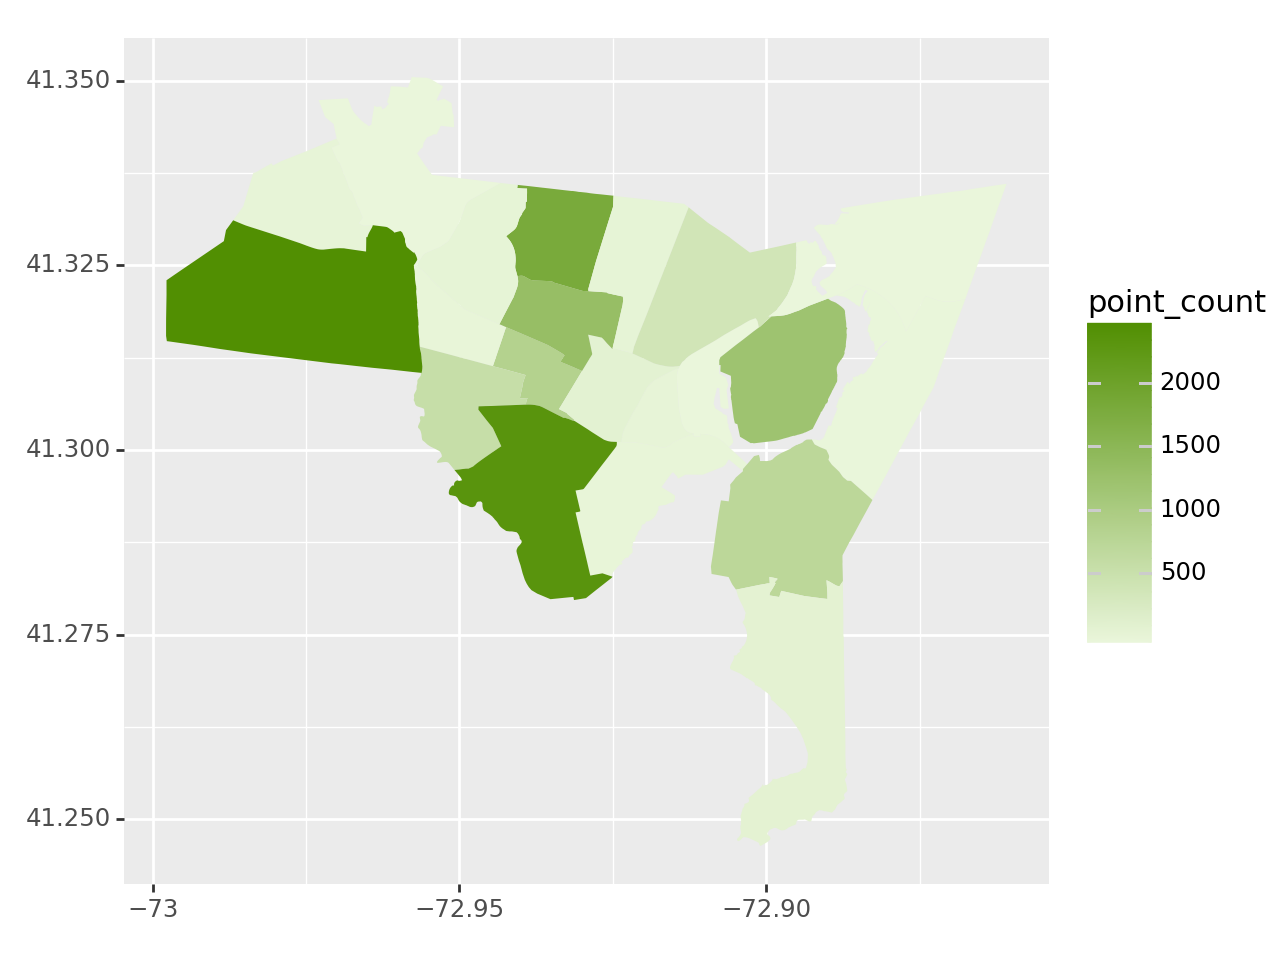

<Figure Size: (640 x 480)>

In [8]:
(
  ggplot()
   + geom_map(nbhds_with_counts, aes(geometry='geometry', fill="point_count"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)